In [6]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""

!python3 -V

Python 3.10.12


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scalar field classes
from utils.sigma_common import sigma
from utils.sigma_funcs import sigma_gauss, sigma_nonconvex, sigma_fract

from utils.toolbox import XY_distrib, gen_random_graph

# ----------------------------------------------------------------------
# Centroid and ascending direction estimation tools
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, kp=1):
    xhat_dt = - kp*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

def dyn_mu_estimation(lhat, t, Lb, kp=1):
    lhat_dt = - kp*(Lb.dot(lhat))
    return lhat_dt

## Centroid estimation

In [3]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # two legends

from utils.toolbox import kw_def_patch, unicycle_patch

def plot_centroid_estimation(ax, X, Z, tf=1, freq_inv=100, kp=1,
                             legend=False, xlab=False, ylab=False):
    N = X.shape[0]

    xc = np.sum(X, axis=0)/N
    xb = X.flatten()

    scale = np.max(np.linalg.norm(X-xc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 0]) # why?

    # Simulation -------------------------------------------------------
    t = np.linspace(0, tf, int(freq_inv*tf+1))
    
    xhat_0 = np.zeros_like(xb)
    xhat = odeint(dyn_centroid_estimation, xhat_0, t, args=(Lb,xb,kp))

    xc_est0 = X
    xc_est = (xb - xhat[-1]).reshape(X.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([xc[0]-ds, xc[0]+ds, xc[1]-ds, xc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N,tf*1000,freq_inv/1e3) + "\n"
    title = title + r"$k_p$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(kp,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([X[edge[0]-1,0], X[edge[1]-1,0]], [X[edge[0]-1,1], X[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(xc[0], xc[1], c="k", marker=r"$x$", s=scale*100)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

### Some examples

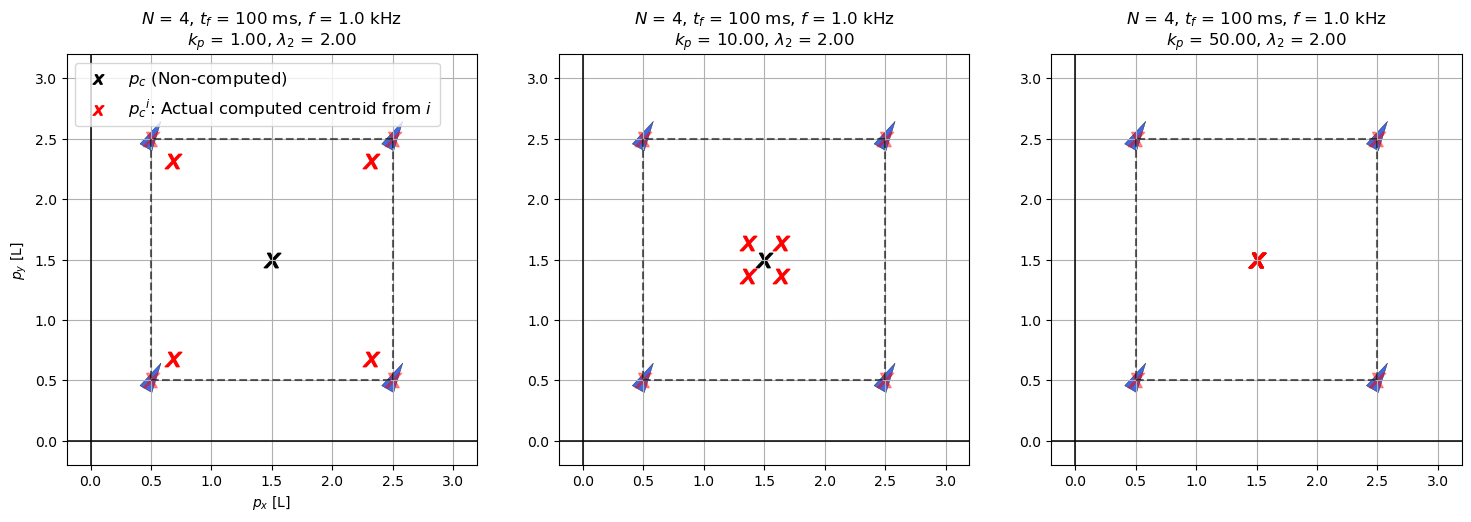

In [5]:
## Parameters #####
p = np.array([[1,1],[-1,1],[-1,-1],[1,-1]]) + np.array([1.5,1.5])
Z = ((1,2), (2,3), (3,4), (4,1))

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, tf=0.1, freq_inv=100*10, kp=1, legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, tf=0.1, freq_inv=100*10, kp=10)
plot_centroid_estimation(ax[2], p, Z, tf=0.1, freq_inv=100*10, kp=50)

# Show the plot!
plt.show()

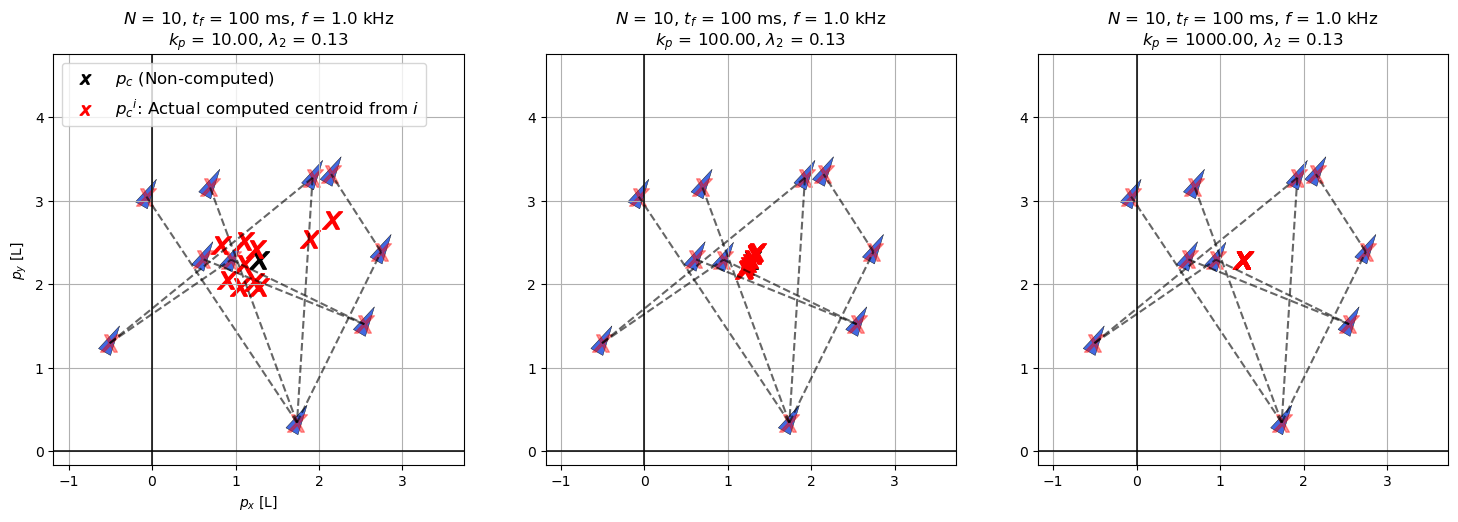

In [6]:
## Parameters #####
pc = np.array([1.2,1.5])
lims = np.array([2,2])

N = 10
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, tf=0.1, freq_inv=100*10, kp=10, legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, tf=0.1, freq_inv=100*10, kp=100)
plot_centroid_estimation(ax[2], p, Z, tf=0.1, freq_inv=100*10, kp=1000)

# Show the plot!
plt.show()

## Ascending direction estimation

In [135]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # two legends

from utils.toolbox import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from utils.toolbox import L_sigma, unit_vec

def plot_L_estimation(ax, P, Z, sigma_field, tf=1, freq_inv=100, kp=1,
                             legend=False, xlab=False, ylab=False):
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()
    X = P - pc

    # Evaluate the scalar field and compute the L_sigma (the not estimated one)
    sigma_values = sigma_field.value(P)
    mu_i_comp = L_sigma(X, sigma_values)

    mu_i = sigma_values[:,None] * X
    mu_i_b = mu_i.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[abs(eig_vals) > 1e-7])

    # Simulation -------------------------------------------------------
    t = np.linspace(0, tf, int(freq_inv*tf+1))
    
    lhat_0 = np.copy(mu_i_b)
    lhat = odeint(dyn_mu_estimation, lhat_0, t, args=(Lb,kp))

    mu0 = mu_i
    mu = lhat[-1].reshape(P.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    scale = np.max(np.linalg.norm(X, axis=1))
    arr_scale = 1.6
    ds = scale + 1

    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N,tf*1000,freq_inv/1e3) + "\n"
    title = title + r"$k_p$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(kp,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    alpha_edges = 0.8/(1+np.log(N))
    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=alpha_edges, zorder=-1)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(P[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=arr_scale*100)

    # Gradient arrow and computed ascending direction L1
    sigma_field.draw_grad(pc, ax, **kw_def_arrow(arr_scale))
    vector2d(ax, pc, unit_vec(mu_i_comp), c="blue", **kw_def_arrow(arr_scale))

    # Estimated ascending direction mu
    for n in range(N):
        vector2d(ax, P[n,:], unit_vec(mu0[n,:]), c="red", alpha=0.3, **kw_def_arrow(arr_scale))
        vector2d(ax, P[n,:], unit_vec(mu[n,:]), c="red", **kw_def_arrow(arr_scale))
    
    # Generate the legend
    if legend:
        arr1 = plt.scatter([],[],c='k',marker=r'$\uparrow$',s=60)
        arr2 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
        arr3 = plt.scatter([],[],c='blue',marker=r'$\uparrow$',s=60)

        leg = Legend(ax, [arr1, arr2, arr3], 
                    [r"$\nabla\sigma$ (Non-computed)",
                    r"$\mu_i$: Actual estimated ascending direction",
                    r"$L_1$: Actual computed ascending direction"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

### Some examples

[ 1.78936304  1.78936304 -1.7815833   1.7815833  -1.77624754 -1.77624754
  1.7839801  -1.7839801 ] 
 [ 0.2452036   0.24402715 -0.23744426  0.2438819  -0.23734929 -0.23852574
  0.24510225 -0.23866461]
---
[ 1.78936304  1.78936304 -1.7815833   1.7815833  -1.77624754 -1.77624754
  1.7839801  -1.7839801 ] 
 [ 0.00829722  0.00709883 -0.00054102  0.00709872 -0.00054104 -0.00173943
  0.00829713 -0.00173942]
---
[ 1.78936304  1.78936304 -1.7815833   1.7815833  -1.77624754 -1.77624754
  1.7839801  -1.7839801 ] 
 [0.00395901 0.00276061 0.00379714 0.00276061 0.00379714 0.00259874
 0.00395901 0.00259874]
---


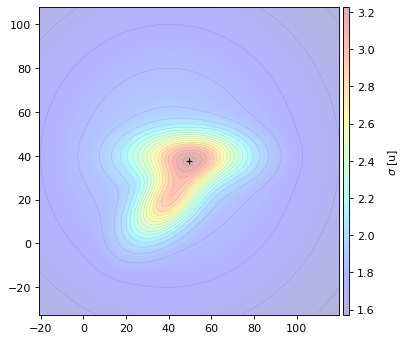

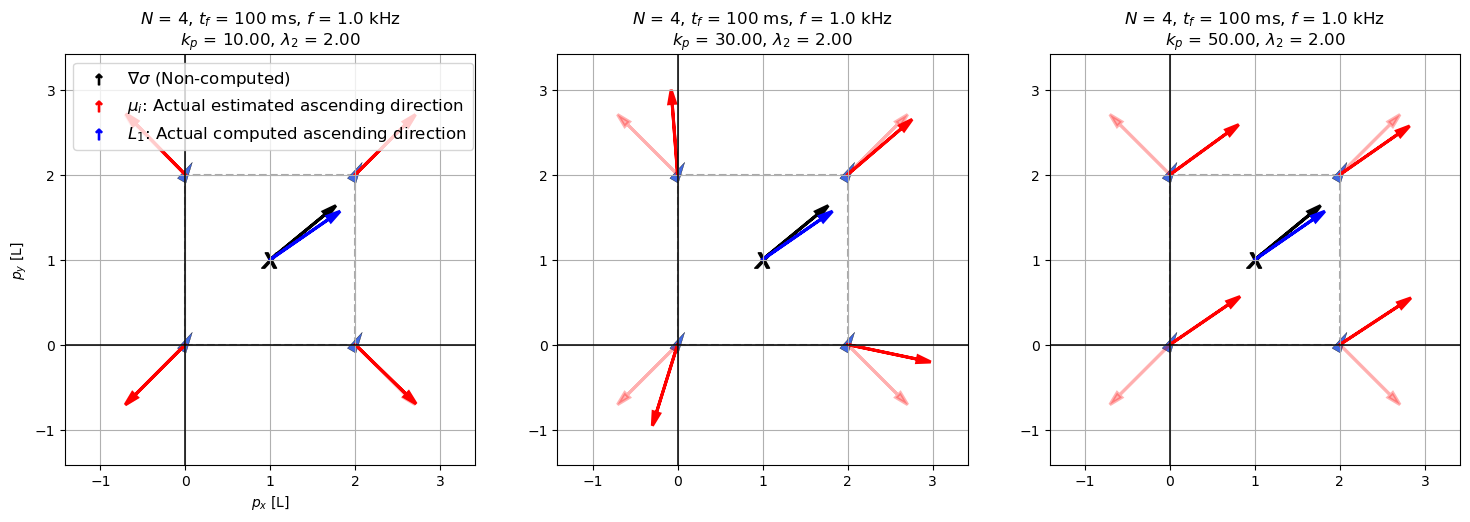

In [134]:
## Parameters #####
p = np.array([[1,1],[-1,1],[-1,-1],[1,-1]]) + np.array([1,1])
Z = ((1,2), (2,3), (3,4), (4,1))

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_L_estimation(ax[0], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=10, 
                  legend=True,xlab=True,ylab=True)
plot_L_estimation(ax[1], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=30)
plot_L_estimation(ax[2], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=50)

# Show the plot!
plt.show()

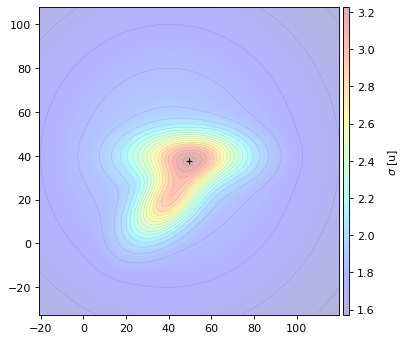

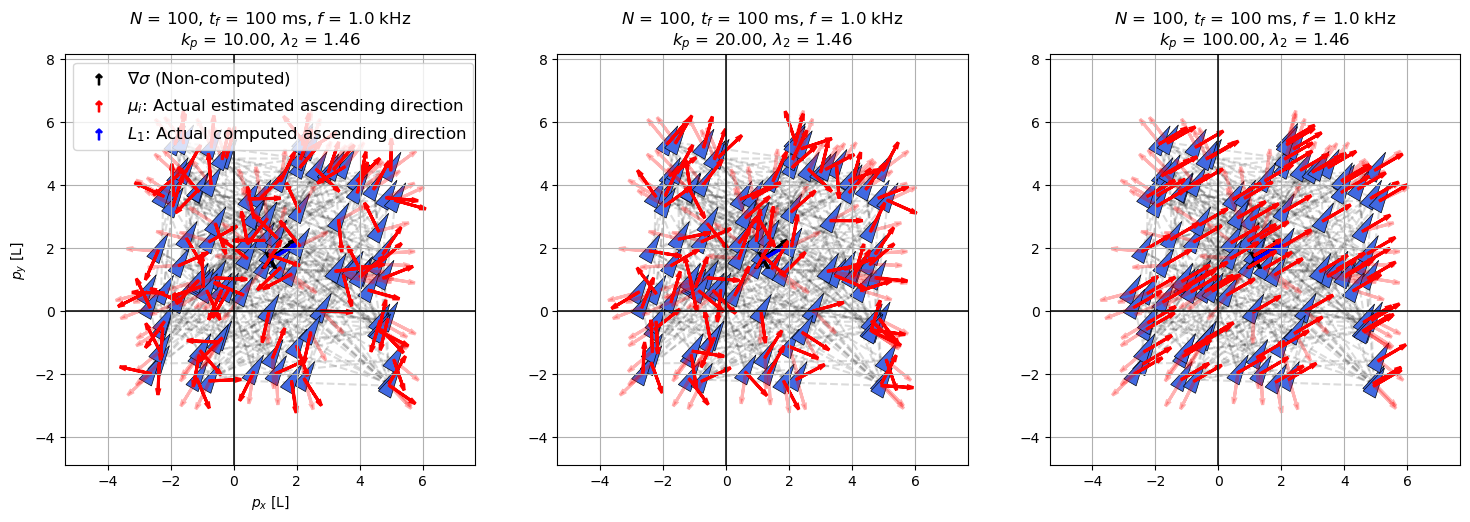

In [127]:
## Parameters #####
pc = np.array([1.2,1.5])
lims = np.array([4,4])

N = 100
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N, rounds=3)

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_L_estimation(ax[0], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=10, 
                  legend=True,xlab=True,ylab=True)
plot_L_estimation(ax[1], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=20)
plot_L_estimation(ax[2], p, Z, sigma_field, tf=0.1, freq_inv=100*10, kp=100)

# Show the plot!
plt.show()

## Centroid + ascending direction estimation

In [145]:
from scipy.integrate import odeint

from utils.toolbox import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from utils.toolbox import angle_of_vectors, unit_vec, L_sigma

# ----------------------------------------------------------------------
# Centroid and ascending direction estimation tools
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat, t, Lb, p, k=1):
    xhat_dt = - k*(Lb.dot(xhat) - Lb.dot(p))
    return xhat_dt

def dyn_mu_estimation(mu, t, Lb, k=1):
    mu_dt = - k*(Lb.dot(mu))
    return mu_dt

# ----------------------------------------------------------------------
# Simulator class
# ----------------------------------------------------------------------

class simulator:
    def __init__(self, q0, Z, sigma_field, dt=1/60, kc=1, kl=1, kd=1,
                 its_c=100, its_l=100):
        # Initial state
        self.q0 = q0
        self.p = q0[0]
        self.v = q0[1]
        self.phi = q0[2]

        # Build the Laplacian matrix
        self.N = self.p.shape[0]

        B = build_B(Z,self.N)
        L = build_L_from_B(B)
        self.Lb = np.kron(L, np.eye(2))

        # Compute algebraic connectivity
        eig_vals = np.linalg.eigvals(L)
        self.lambda2 = np.min(eig_vals[abs(eig_vals) > 1e-7])

        # Scalar field
        self.sigma_field = sigma_field
        self.sigma = np.zeros((self.N,1))

        # Simulation parameters and control variables
        self.kc = kc
        self.kl = kl
        self.kd = kd

        self.pc_hat = np.zeros_like(self.p)
        self.pc_comp = np.zeros(2)
        self.x = np.zeros_like(self.p)

        self.mu = np.zeros_like(self.p)
        self.mu_comp = np.zeros_like(self.p)

        self.omega = np.zeros(self.N)

        # Integrator and ED solver parameters
        self.t = 0
        self.dt = dt
        self.tc = np.linspace(0, its_c, its_c+1)
        self.tl = np.linspace(0, its_l, its_l+1)

        # Simulation data providerdata_pc_hat
        self.data = {"t": [], "p": [], "phi": [], "pc_hat": [], "mu": [],
                     "pc_comp": [], "mu_comp": []}

    def update_data(self):
        """
        Update the data dictionary
        """
        self.data["t"].append(self.t)
        self.data["p"].append(self.p)
        self.data["phi"].append(self.phi)
        self.data["pc_hat"].append(self.pc_hat)
        self.data["mu"].append(self.mu)
        self.data["pc_comp"].append(self.pc_comp)
        self.data["mu_comp"].append(self.mu_comp)

    def restart(self):
        self.p = self.q0[0]
        self.v = self.q0[1]
        self.phi = self.q0[2]

        self.t = 0
        for key in self.data.keys():
            self.data[key] = []
        
    def get_pc_estimation(self):
        """
        Distributed estimation of the centroid
        """
        pb = self.p.flatten()
        xhat_0 = np.zeros_like(pb)
        xhat = odeint(dyn_centroid_estimation, xhat_0, self.tc, args=(self.Lb,pb,self.kc))

        pc_hat = (pb - xhat[-1]).reshape(self.p.shape)
        return pc_hat
    
    def get_mu_estimation(self):
        """
        Distributed estimation of the ascending direction
        """
        mu_i = self.sigma * self.x
    
        lhat_0 = np.copy(mu_i.flatten())
        lhat = odeint(dyn_mu_estimation, lhat_0, self.tl, args=(self.Lb,self.kl))
        
        mu = lhat[-1].reshape(self.x.shape)
        return mu

    def mu_tracking_control(self):
        """
        Compute the control law to track the ascending direction mu
        """
        p_dot_unit = np.array([np.cos(self.phi), np.sin(self.phi)]).T
        omega = - self.kd * angle_of_vectors(self.mu, p_dot_unit)
        return omega

    # ----- UNICYCLE  KINEMATICS
    def unicycle_kinematics(self):
        p_dot = self.v * np.array([np.cos(self.phi), np.sin(self.phi)]).T
        phi_dot = self.omega
        return p_dot, phi_dot

    # ----- EULER INTEGRATION
    def int_step(self):
        """
        Euler integration (Step-wise)
        """
        
        # Centroid estimation
        self.pc_hat = self.get_pc_estimation()
        self.pc_comp = np.mean(self.p, axis=0)

        self.sigma = self.sigma_field.value(self.p)[:,None]
        self.x = self.p - self.pc_hat

        # Ascending direction estimation
        self.mu = self.get_mu_estimation()
        self.mu_comp = L_sigma(self.p-self.pc_hat, self.sigma_field.value(self.p))

        # Compute the mu tracking control input
        self.omega = self.mu_tracking_control()

        # Robot dynamics integration
        p_dot, phi_dot = self.unicycle_kinematics()

        self.t = self.t + self.dt
        self.p = self.p + self.dt*p_dot
        self.phi = self.phi + self.dt*phi_dot

        # Update output data
        self.update_data()

### Some examples

In [163]:
## Parameters #####
pc = np.array([10,70])
lims = np.array([4,4])

N = 10
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = gen_random_graph(N, rounds=3)

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
q0 = [p, 2, phi]

sim = simulator(q0, Z, sigma_field, dt=dt, kc=1, kl=0.3, its_c=5, its_l=15)

In [165]:
# Execute the simulation given a desired final time stamp
tf = 40
its = int(tf/dt)

sim.restart()
for it in tqdm(range(its)):
    sim.int_step()

100%|██████████| 2400/2400 [00:05<00:00, 453.71it/s]


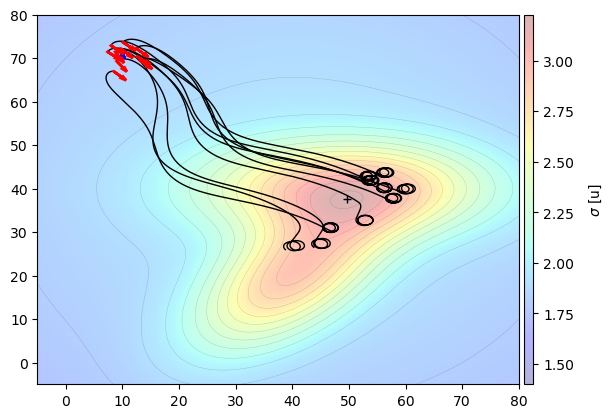

In [166]:
# -- Plot position during the whole simulation and estimations at t=0
kw_arr = {"lw":2, "hw":0.5, "hl":1}

# Collect data from the simulation
data_p = np.array(sim.data["p"])
data_pc_hat = np.array(sim.data["pc_hat"])
data_mu = np.array(sim.data["mu"])

fig = plt.figure()
ax = fig.subplots()

# Axes config
ax.set_xlim([-5,80])
ax.set_ylim([-5,80])

# Draw the scalar field
kw_draw_field = {"xlim":2*50, "ylim":2*50, "n":400, "contour_levels":20}
sim.sigma_field.draw(fig, ax, **kw_draw_field)

for n in range(N):
    # Position
    ax.plot(data_p[:,n,0], data_p[:,n,1], c="k", zorder=1, lw=1)

    # Estimated ascending direction mu
    li = 0
    vector2d(ax, data_p[li,n,:], unit_vec(data_mu[li,n,:])*3, c="red", **kw_arr, zorder=3)
    ax.scatter(data_pc_hat[li,n,0], data_pc_hat[li,n,1], c="b", marker=r"$x$", s=30)

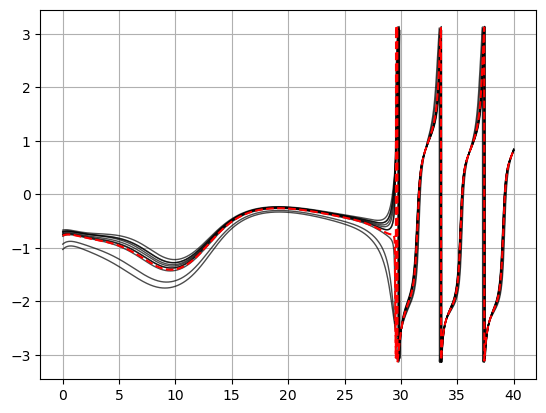

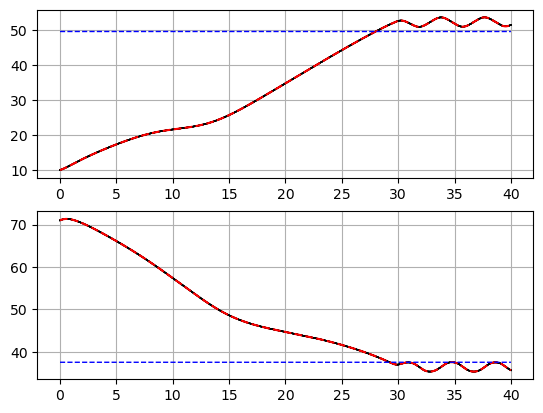

In [167]:
# -- Plot the estimations during the whole simulation
data_t = np.array(sim.data["t"])
data_pc_hat = np.array(sim.data["pc_hat"])
data_pc_comp = np.array(sim.data["pc_comp"])
data_p_sigma = sim.sigma_field.mu
data_mu = np.array(sim.data["mu"])
data_mu_comp = np.array(sim.data["mu_comp"])

psi_mu = np.arctan2(data_mu[:,:,1], data_mu[:,:,0])
psi_mu_comp = np.arctan2(data_mu_comp[:,1], data_mu_comp[:,0])

# mu estimation
fig = plt.figure()
ax = fig.subplots()
ax.grid(True)

ax.plot(data_t, psi_mu, c="k", alpha=0.7, lw=1)
ax.plot(data_t, psi_mu_comp, c="r", ls="--")

# centroid estimation
fig = plt.figure()
ax1, ax2 = fig.subplots(2,1)
ax1.grid(True)
ax2.grid(True)

ax1.plot(data_t,data_pc_hat[:,:,0], c="k", alpha=0.7, lw=1)
ax1.plot(data_t,data_pc_comp[:,0], c="r", ls="--")
ax1.plot(data_t, np.ones_like(data_t)*data_p_sigma[0], c="b", ls="--", lw=1)

ax2.plot(data_t,data_pc_hat[:,:,1], c="k", alpha=0.7, lw=1)
ax2.plot(data_t,data_pc_comp[:,1], c="r", ls="--")
ax2.plot(data_t, np.ones_like(data_t)*data_p_sigma[1], c="b", ls="--", lw=1)

plt.show()